# Neural Style Transfer using Keras and TensorFlow

A very interesting and entertaining application of machine learning is Neural Style Transfer. First described in [this paper](https://arxiv.org/abs/1508.06576) by Leon Gatys, Alexander Ecker, and Matthias Bethge, it is an algorithm that is able to create novel works of art from a simple photograph. Essentially, what it does is imitate the style of a certain painting and replicate it in a photo of your choosing.

## What this project aims to do

This project aims to provide a simple and intuitive overview of how the algorithm works, based entirely on the original paper as well as Professor Andrew Ng's ideas in his [deeplearning.ai course](https://www.coursera.org/learn/convolutional-neural-networks). It also aims to provide a simple implementation of the paper, using the popular Deep Learning libraries Keras and Tensorflow. This is partly out of frustration, as I found it hard to come across a simple example that implemented this algorithm from scratch using Tensorflow. The implementation is fully documented and easily modifiable.

If you are already familiar with how the algorithm works, feel free to skip ahead to the **Implementation** section. 

If you simply want to try generating your own images, scroll down until the end of the notebook, to **Let's Generate Some Art!**.

## How it works

So, how does an _algorithm_ generate art? Isn't that supposed to be an innately human quality?

Sort of.

### Defining the problem

What we aim to do is this: given a content image $I_c$, we would like to generate a new image $I_g$ which replicates the style of some style image, $I_s$. For example:

| Content image $I_c$ | Style image $I_s$ | Generated image $I_g$ |
| ------------- |-------------| --------|
| 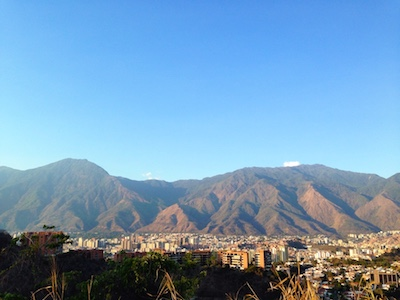 | 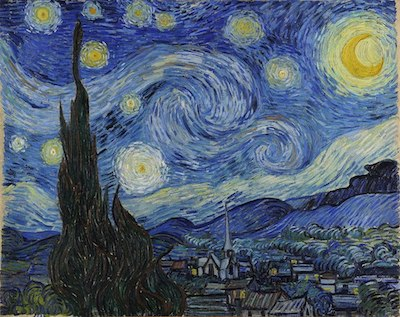|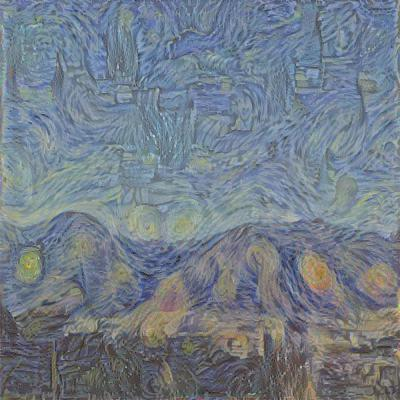 |


To be able to achieve this, we will be using **machine learning** and **function minimization**.

### Setting up the loss

What we want to do is define a function that can take as input our three images $I_c$, $I_s$, and $I_g$, and tell us how different our generated image is from our content image, as well as how different the style of our generated image is from our style image. If the number returned by our function is high, this means that the generated image is far from looking like our content and style images. On the other hand, if the number returned is low, it means that the generated image is similar in content and style to our other images, respectively.

#### Representing the images

To do this, we first need a way of representing these images in a useful format. We do this by representing our three images as three-dimensional matrices of shape $(height, width, channels)$ that contain numbers ranging from $0$ to $255$ (a way of representing colour in a computer). If we are working with colour images, then the $channels$ dimension will be $3$, as we will have red, green, and blue channels. If we are working with grayscale images, we should only have one channel.

However, to the computer, that is just a bunch of numbers. What would be ideal is to have a representation of what the images _actually_ are. A dog? A house? A person? To do this, we will use a pre-trained state of the art **convolutional neural network**.

A convolutional neural network (CNN for short) is essentially a sequence of matrix operations on an image that eventually gives us a numerical representation of what is in it. The details of how they work will not be included here for brevity, but a quick primer can be found [here](http://cs231n.github.io/convolutional-networks/). The network can have many layers, and you can think of each layer as intuitively recognizing the features present in an image, progressing from the lowest-level features (for example, where vertical and horizontal edges are located in the image) to higher-level features (elaborate combinations or patterns of those lower level features, like a dog, or a person, or a house).

_An example of a CNN, taken from Andrew Ng's deeplearning.ai course. Each "rectangle" is a 3-D matrix of numbers, representing an intermediate layer inside the neural network._
![An example of a CNN](https://cdn-images-1.medium.com/max/1600/1*jqKHgwZ8alM3K_JRYO_l4w.png)

By passing our images as input to a CNN, we obtain several intermediate "layers", which are new matrices that you can intuitively think of as representations of the features present in an image. The intermediate layers in these matrices are called "activations", because you can think of each number in them as "neurons" that "activate" (i.e, have a high numerical value) when a specific feature is detected in that part of the image.

We can then use these activations as better representations of our images! Then, we define a function that takes in these three matrices as inputs, and gives us useful information about how far off we are from obtaining our desired result. To do this, we will first define two separate functions, which we will then use to compose the final one.

#### Content loss

The first function, which we will call $C(I_g, I_c)$, will tell us how far off our generated image $I_g$ is from the content image $I_c$. The definition is relatively simple:

$$ C(I_g, I_c) = \sum | I_g - I_c |^2 $$

We will take the absolute squared difference of both matrices, and then sum over each and every element of the resulting matrix. This will give us a final positive number, which represents how far apart the generated image $I_g$ is from the content image $I_c$ - the higher the number, the greater the difference between both matrices, and therefore the more different they are.

It is possible to use both the original image matrices $I_g$ and $I_c$ here, or an intermediate representation of these images after passing them through a CNN and obtaining their activations. The latter would simply require us to pass the matrices as inputs to our CNN first, and then pick one of the intermediate layers as the representations.

*_Note_*: when implementing the NST algorithm, using the squared difference between both image matrices _without_ passing them through the network first seems to work just as well. In some circumstances, the absolute squared difference alone may be faster than using the CNN and then computing the squared difference.

#### Style loss

The second function, which we will call $S(I_g, I_s)$, will tell us how different the styles of our generated image and our style image are. The definition of this function is a bit more complex.

First, we need a way to represent the _style_ of an image, not its content. It turns out that a fairly good representation of the style of a certain image is taking the [**gram matrix**](https://en.wikipedia.org/wiki/Gramian_matrix) of each of its activation matrices after passing it through a CNN. The gram matrix of a matrix $X$ is defined as the multiplication of itself by its transpose.

$$ X_{gram} = X^T X $$

To take the gram matrix of the activations, we first unroll the original activation matrix from a (height, width, channels) shape into a (height * width, channels) shape, putting all of the neurons in each channel on a single row and obtaining a 2-D matrix. The resulting matrix after taking the gram matrix of the unrolled activation is one that (roughly) indicates how correlated the different activations in the image are, and how prevalent are certain features in the image. The intuition behind this is the following:

- If there are certain features present in the image, then individual "neurons" in the activation matrix will have been "activated", meaning they have a relatively large value, or are at least greater than 0.
- If we then transpose the matrix, and multiply it by itself, those "activated" neurons will produce large numbers if multiplied with other "activated" neurons (other features that have been detected in the image), and produce smaller numbers if they are multiplied with "de-activated" neurons (features that are not present, and thus have a value of 0 or close to 0).
- The resulting matrix will therefore indicate whether features are ocurring together, or not ocurring together, by producing high values or low values in positions along the matrix - loosely, the correlation between different features in the image. This gives us a representation of the **style** of the image.

With this representation, we can then similarly define a function to represent the difference in style as follows:

1. Compute the intermediate activations corresponding to the images $I_g$ and $I_s$ by running them through the CNN.
2. For the activations corresponding to each layer $l$, we compute the reduced sum of the squared difference of the two activations $A_{l_g}$ and $A_{l_s}$:
$$ D_l = \sum | A_{l_g} - A_{l_s} |^2 $$

3. We then sum up all the squared differences computed for each layer.

Thus, our function is essentially

$$ S(I_g, I_s) = \sum_{l = 0}^{n} D_l(A_{l_g}, A_{l_s}) $$

Where $l$ represents each layer of the CNN, $n$ is the total number of layers chosen, and $D_l$ is the function described above.

In practice, it is useful to pick layers spanning the whole length of the CNN, due to the nature of the features that each layer detects. The first layers typically detect low-level features, such as brush strokes, whilst the later layers detect higher-level features, like shapes and patterns - thus, by computing the squared differences across all of these layers, we can identify style differences not only in low-level texture details, but also in higher-level patterns.


#### Overall loss

We can now define the overall "loss" of our three images - how they differ in content and style. The overall function is defined as the sum of the functions defined previously:

$$ J(I_g, I_c, I_s) = (\alpha * C(I_g, I_s)) + (\beta * S(I_g, I_s)) $$

Where the constants $\alpha$ and $\beta$ are weightings for each respective loss. If we want the generated image to give more importance to the style over representing the original content truthfully, we would give $\beta$ a higher value than $\alpha$, for example.

### Minimizing our loss function

Now that we have a function $J$ that tells us how different in style and content our generated image is from the target images (the bigger the output of the function, the more different in style and content is our generated image, and vice-versa), we have to minimize it: attempt to find a value for the individual pixels of our image $I_g$ for which our loss function $J$ gives the smallest value. How do we do this?

The essential idea to minimize our function is described by the gradient descent algorithm:

1. Differentiate our function $J$ with respect to each number in our image matrix $I_g$ to obtain a gradient. Think of each number in our matrix as an individual variable.
2. Once we obtain a new matrix containing all of our respective partial gradients, we update each component in our image matrix by the negative of its corresponding gradient multiplied by a constant called the **learning rate**. For instance, once we differentiate each variable in our image matrix to obtain a matrix of gradients $G$, we update our image matrix with the following rule:
$$ I_g := I_g - (r * G) $$
where $r$ is our learning rate.
3. Continuously carry out this iterative process until we arrive at a good enough minimum for our function $J$.

This is a _very_ simplified explanation of gradient descent, for the sake of brevity. A more thorough explanation can be found [here](https://towardsdatascience.com/gradient-descent-simply-explained-1d2baa65c757).

We are now ready to start implementing this algorithm!


--------

## Implementation

For the implementation, we will be using the Keras library to load the pre-trained CNN, and the Tensorflow library to define and minimize our loss functions. Keras comes pre-packaged in Tensorflow.

### Setup

First, we will import everything we need.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import os

# tell Jupyter to display all our plots inline in the notebook
%matplotlib inline

### Eager execution

As a start, we enable TensorFlow's Eager Execution mode. This will allow us to evaluate the value of tensors instantly instead of having to build a computational graph and run it. This mode is particularly useful to us because it allows us to seamlessly work with Keras models out of the box in our loss functions, and saves us the pain of managing multiple graphs and sessions.

In [ ]:
tf.enable_eager_execution()

Now that we've imported everything, we can start defining the functions and variables that we will use (described in the previous section). For our pre-trained CNN, we'll be using the [VGG19 network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), made by Oxford University's Visual Geometry Group. The network is state of the art, and performs very well on the ImageNet standard benchmark. The paper can be found [here](https://arxiv.org/abs/1409.1556).

The functions are:

- `compute_total_cost_vgg19`: the function that we will be minimizing in order to generate our image. Computes the overall "cost", or "loss", of our model.
- `get_vgg19_model`: returns the VGG19 architechture as a Keras Model, with preloaded weights trained on ImageNet.
- `compute_vgg19_gradients`: does exactly what it says - computes the gradients of our loss function (which uses the VGG19 model, hence the name) which we then use to optimize our loss function. We explicitly compute the gradients this way in order to be able to apply gradient clipping if necessary.

And our variable for image size:

- `DEFAULT_INPUT_SIZE`: the size of the images we will be feeding in, as well as the size of the image generated.
- `STYLE_LAYERS_VGG19`: the layers of the VGG19 net that we'll be using to compute our style loss function.

In [ ]:
# The size of the input images, as well as the image generated.
# Increasing the height and width will increase the resolution of the generated image,
# but it will take more time to produce.
DEFAULT_INPUT_SIZE = (400, 400, 3)

# The layers from the VGG net that we'll use to compute the style loss.
# We also apply a corresponding weighting, if we want to give more importance to certain layers.
# An equal weighting works well, but others can be tried.
STYLE_LAYERS_VGG19 = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

def get_vgg19_model():
    """
    Fetches the VGG19 model ready for use in our loss functions.
    
    Returns:
    tf.keras.models.Model() -- A Keras model that takes in an image as input, and returns the layers that
                              were defined in the STYLE_LAYERS_VGG19 constant as output.
    """
    vgg19 = tf.keras.applications.vgg19.VGG19(input_shape=DEFAULT_INPUT_SIZE, include_top=False, weights="imagenet")
    vgg19.trainable = False
    style_outputs = [vgg19.get_layer(name).output for name, weight in STYLE_LAYERS_VGG19]
    return tf.keras.models.Model(vgg19.input, style_outputs)

def compute_content_cost(a_C, a_G, model):
    """
    Computes the content cost.

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C) representing the image C (original image).
    a_G -- tensor of dimension (1, n_H, n_W, n_C) representing the image G (generated image).
    model -- Keras model that outputs the intermediate layer activations.

    Returns:
    J_content -- scalar representing the cost. The number is higher if the images are different.
    """
    # run through CNN. We'll be using the fourth layer to compute the content cost.
    a_C_act, a_G_act = model(a_C)[3], model(a_G)[3]
    
    # get dimensions
    num_batch, height, width, channels = a_C_act.numpy().shape

    # unroll into a 2D matrix, with each channel taking up an entire row.
    # We don't really need it here, but we will need it to compute the gram matrices, so it's only logical.
    a_C_unroll = tf.reshape(tf.transpose(a_C_act, perm=[0,3,2,1]), shape=[height * width, channels, num_batch])
    a_G_unroll = tf.reshape(tf.transpose(a_G_act, perm=[0,3,2,1]), shape=[height * width, channels, num_batch])

    # compute the sum and squared difference over the resulting matrix.
    # we're using a regularizing constant, but this shouldn't really matter that much.
    J_content = (1.0 / (4 * height * width * channels)) * tf.reduce_sum(tf.squared_difference(a_C_unroll, a_G_unroll))

    return J_content

def gram_matrix(A):
    """
    Computes the "style" matrix of an image.

    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    gram -- Gram matrix of A, of shape (n_C, n_C)
    """
    gram = tf.matmul(A, tf.transpose(A))
    return gram

def compute_layer_style_cost(a_S, a_G):
    """
    Computes the style cost, i.e how similar the styles of a certain layer
    of the images are. This is done by finding the correlation between different channels
    in the activations of the image.

    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    cost -- scalar value, style cost.
    """
    # get dimensions
    num_batch, height, width, channels = a_S.numpy().shape

    # unroll into a 2D matrix, where each channel takes up a whole row.
    # this enables us to compute the gram matrices and get a representation of the style of the images.
    a_S_unroll = tf.reshape(tf.transpose(a_S, perm=[3,2,1,0]), shape=[channels, width * height])
    a_G_unroll = tf.reshape(tf.transpose(a_G, perm=[3,2,1,0]), shape=[channels, width * height])

    # compute gram matrices
    a_S_gram = gram_matrix(a_S_unroll)
    a_G_gram = gram_matrix(a_G_unroll)

    # regularization constant
    reg_const = (1.0 / (4 * ((height * width) ** 2) * (channels ** 2)))
    
    # compute the style cost for the specific layer
    cost = reg_const * tf.reduce_sum(tf.squared_difference(a_S_gram, a_G_gram))

    return cost


def compute_style_cost(a_G, a_S, model, STYLE_LAYERS, verbosity=0):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    a_G -- Tensor of dimension (1, n_H, n_W, n_C) representing our generated image.
    a_S -- Tensor of dimension (1, n_H, n_W, n_C) representing our style image.
    model -- our Keras model of the CNN.
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a weighting coefficient for each of them
    verbosity -- Flag that indicates whether we should print each layer's style cost.

    Returns:
    J_style -- scalar, sum over the style costs of each layer
    
    """
    # initialize the overall style cost
    J_style = 0.

    # get our intermediate layer activations
    a_G_acts = model(a_G)
    a_S_acts = model(a_S)

    # loop over the layers we want to use for the cost
    for index, output in enumerate(a_G_acts):
        
        # get name and relative weighting of layer
        name, weight = STYLE_LAYERS[index]
        
        # get the corresponding activations for each image for the current layer
        a_G_act = output
        a_S_act = a_S_acts[index]

        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S_act, a_G_act)

        if verbosity >= 2:
            print("Layer {}, cost {}".format(name, J_style_layer))

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer

    return J_style


def compute_total_cost_vgg19(a_G, a_C, a_S, model, alpha = 10, beta = 40, verbosity=0):
    """
    Computes the overall cost, or loss, of our image.
    
    Arguments:
    a_G -- Tensor of shape (1, n_H, n_W, n_C) representing our generated image.
    a_C -- Tensor of shape (1, n_H, n_W, n_C) representing our content image.
    a_S -- Tensor of shape (1, n_H, n_W, n_C) representing our style image.
    model -- A Keras CNN model.
    alpha -- The weighting for the content cost.
    beta -- The weighting for the style cost.
    verbosity -- Flag to indicate logging level (0, 1, or 2).
    
    Returns:
    cost -- Scalar with overall cost/loss.
    """

    content_cost = compute_content_cost(a_C, a_G, model)
    style_cost = compute_style_cost(a_G, a_S, model, STYLE_LAYERS_VGG19, verbosity=verbosity)
    cost = (alpha * content_cost) + (beta * style_cost)

    if verbosity >= 1:
        print("Content cost -- {}; Style cost -- {}".format(content_cost, style_cost))

    return cost

def compute_vgg19_gradients(a_G, a_C, a_S, model, alpha = 10, beta = 40):
    """
    Computes the gradients of a_G relative to our overall loss function. Takes in the same parameters as compute_total_cost_vgg19
    """
    # use Tensorflow's gradient tape feature, that allows us to "record" certain operations on a tape
    # and then "rewind" it to backpropagate and obtain gradients
    with tf.GradientTape() as tape:
        cost = compute_total_cost_vgg19(a_G, a_C, a_S, model, alpha = alpha, beta = beta)
    # return the gradients with respect to a_G
    return tape.gradient(cost, a_G)


### Preprocessing our data

The VGG19 paper states that their model uses certain preprocessing before feeding images into the network. For our model to work, we must also carry out this preprocessing.

Furthermore, if we want our generated image to be visually pleasing as well, we also have to deprocess it when we save it, carrying out the reverse process. Hence, we define two helper functions.

In [ ]:
def vgg19_preprocess(img):
    """
    Preprocesses the image matrix _img_ as was done in the VGG paper. Means are subtracted from each pixel corresponding
    to their channels.
    """
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)).astype(np.float32)
    # Substract the mean to match the expected input of VGG19
    img = img - MEANS

    return img


def vgg19_deprocess(img):
    """
    Deprocesses the image matrix _img_. Means are added to each pixel corresponding
    to their channels.
    """
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)).astype(np.float32)
    # Substract the mean to match the expected input of VGG19
    img = img + MEANS

    return img

We also define some utility functions for when we save and load the images we'll use. We don't have to worry much about them.

In [ ]:
def checkdir(path):
    # If the path exists, do nothing. If not, create a directory to store the image.
    if os.path.isdir(path):
        return 0
    else:
        os.mkdir(path)


def save_image(raw_image, path, name, epoch, deprocessing=None):
    """
    Saves the image _raw_image_ (not been deprocessed yet) to the directory _path_, with the name 
    _name_. The deprocessing argument accepts a function to use for deprocessing the image.
    """
    # use the specified deprocessing function when saving our image.
    # if there is no deprocessing function, don't do anything to it.
    if deprocessing is not None:
        raw_image = deprocessing(raw_image)
    
    # reshape from (1, DEFAULT_INPUT_SIZE) to (DEFAULT_INPUT_SIZE) for saving
    image = raw_image.numpy().reshape(DEFAULT_INPUT_SIZE)

    # check directory exists
    checkdir(path)

    # save our image
    scipy.misc.imsave("{}/{}_at_epoch_{}.jpg".format(path, name, str(epoch)), image)
    
    
def load_image(path, preprocessing=None, print_image=False):
    """
    Loads the image and converts it to a Numpy array of shape (1, DEFAULT_INPUT_SIZE). Also carries out
    the preprocessing necessary to run through the net, according to the preprocessing argument which accepts a function.
    Can also print the image after to confirm that it has been done correctly if print_image is True.
    """
    # read image and resize it to the size we need
    image = scipy.misc.imread(path)
    image = scipy.misc.imresize(image, size=(DEFAULT_INPUT_SIZE[0], DEFAULT_INPUT_SIZE[1]))
    
    # reshape into the shape our net accepts
    image = image.reshape((1, ) + DEFAULT_INPUT_SIZE).astype(np.float32)

    if print_image:
        imshow(image.reshape(DEFAULT_INPUT_SIZE))
        plt.show()
        
    # carry out preprocessing
    image = preprocessing(image)

    return image

### Initializing our image

To initialize the image we will be minimizing our cost function over, we use the content image (the image that will be re-painted in the style of another) to generate a new image that is not so far off from the original one - this way, our algorithm can converge faster and not worry too much about replicating the content in the photo as well as applying a new style. We do this by mixing in some random noise to the original image.

In [ ]:
def create_noise_image(content_image, noise_ratio):
    """
    Creates a noise image from the content_image
    
    Arguments:
    content_image -- Tensor of shape (1, n_H, n_W, n_C) representing the ALREADY PRE-PROCESSED image.
    noise_ratio -- The degree of noise to add to the image, ranging from 0 to 1. 
    
    Returns:
    input_image -- A tfe.Variable containing our generated image.
    """
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, ) + DEFAULT_INPUT_SIZE).astype('float32')

    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = (noise_image * noise_ratio) + (content_image * (1 - noise_ratio))
    
    # create our TensorFlow variable that will be optimized during each step
    input_image = tfe.Variable(input_image, name="generated_image", dtype=tf.float32)

    return input_image

### Training

We are finally ready to train our model! Our train function will iteratively use the [Adam optimizer](https://arxiv.org/abs/1412.6980) (a fancy version of gradient descent that converges faster) to minimize the cost function defined above, and slowly adjust the pixel values in our generated image to create our art. 

In [ ]:
def train(content_image, style_image, model=None, deprocessing=None, cost_func=compute_total_cost_vgg19, epochs=1500, learning_rate=2, save_every=20, save_dir="", filename="", verbosity=0):
    """
    Performs gradient descent on our loss function and optimizes our generated image variable
    
    Arguments:
    content_image -- Tensor representing our content image, shape (1, n_H, n_W, n_C). Already preprocessed.
    style_image -- Tensor representing our style image, shape (1, n_H, n_W, n_C). Already preprocessed.
    model -- the Keras CNN model to use in our cost function.
    deprocessing -- The function used to de-process an image before saving it.
    cost_func -- The cost function to minimize.
    epochs -- Number of iterations to run the algorithm for. A number between 1500 - 2000 works well.
    learning_rate -- Learning rate for the Adam optimizer. 1.2 yields good results, 2 converges faster (but may overshoot towards the end).
    save_every -- number that indicates the steps to progressively save the generated image. For example, =20 means
                  the generated image will be saved to disk every 20 iterations.
    save_dir -- Directory to save the generated images.
    filename -- the filename to save the generated image as. Will have a "at_epoch_xx.jpg" appended at the end.
    verbosity -- Indicates the level of logging output. Can be 0, 1, or 2.
    """
    # assign our content and style images to representative variables.
    a_C, a_S = content_image, style_image

    # create our generated image
    a_G = create_noise_image(a_C, 0.6)

    # we will be using the Adam optimizer to minimize our function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    # iterate over the number of epochs
    for epoch in range(epochs):

        # compute our gradients with respect to the a_G variable.
        grads = compute_vgg19_gradients(a_G, a_C, a_S, model)
        
        # uncomment this line and comment the subsequent one if you wish to use gradient clipping.
        #capped_grads = tf.clip_by_value(grads, -20., 20.)
        capped_grads = grads
        
        # apply gradients and perform one step of minimization to our image.
        optimizer.apply_gradients([(capped_grads, a_G)])

        # print our loss
        print("Loss: {} --- Step {}".format(cost_func(a_G, a_C, a_S, model, verbosity=verbosity), epoch))

        # every save_every epochs, we will save the current image in the save_dir directory using the filename "filename".
        if epoch % save_every == 0:
            save_image(a_G, save_dir, filename, epoch, deprocessing=deprocessing)

## Let's generate some art!

Now, we just need to load the images we want to use and provide the adequate starting configuration.

Modify the code below to select the images you wish to use, and then run!

In [ ]:

# START HERE
# replace these constants with the parameters you want to use

# filename of the content image. Make sure it is in the same directory as this notebook.
CONTENT_IMAGE = "blue-marble.jpg"
# style image.
STYLE_IMAGE = "starry-night.jpg"
# directory where program will save the generated images.
SAVE_DIR = "blue_marble_vg"
# filename to give the generated images
FILENAME = "blue_marble_vg"


content_img = load_image(CONTENT_IMAGE, print_image=False, preprocessing=vgg19_preprocess)
style_img = load_image(STYLE_IMAGE, print_image=False, preprocessing=vgg19_preprocess)

# initialize model
model = get_vgg19_model()

# making sure we don't modify the weights in our model
for layer in model.layers:
    layer.trainable = False

# train! 
# you can try playing around with the 
train(content_img, 
      style_img, 
      model=model, 
      cost_func=compute_total_cost_vgg19, 
      deprocessing=vgg19_deprocess,
      save_every=20,
      save_dir=SAVE_DIR, 
      filename=FILENAME, 
      learning_rate=1.2,
      verbosity=1,
      epochs=1850
     )


## Running in Google Colaboratory

The ideal way to run this notebook is using Google's Colaboratory, which provides a free-to-use GPU that can _greatly_ accelerate training. Go to [Google Colab](https://colab.research.google.com/) and select "Upload a notebook", and then select this .ipynb file from your computer. 

Once you've loaded it, select "Change runtime type" from the "Runtime" menu, and click on the option to use a GPU. The availability of the GPU may vary, but you should eventually manage to connect to it. After this, make sure you upload the image files that you want to use to Google Colab using the "Files" tab in the sidebar menu (you might have to open the menu first). After that, enjoy!